<a href="https://colab.research.google.com/github/PranavDixit2/StockPred/blob/main/StockPred_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
import tensorflow as tf


In [97]:
# Function to fetch stock data with input validation
def fetch_stock_data(ticker):
    try:
        stock_data = yf.download(ticker)
        if stock_data.empty:
            raise ValueError("No data found. Please check the ticker symbol.")
        print("Stock data fetched:")
        print(stock_data.tail(5))
        return stock_data
    except Exception as e:
        print(f"Error fetching stock data: {e}")
        exit()


In [98]:
# Function to calculate EMA
def calculate_ema(data, span):
    return data['Close'].ewm(span=span, adjust=False).mean()

# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    sma = data['Close'].rolling(window=window).mean()
    std_dev = data['Close'].rolling(window=window).std()
    data['Bollinger_Upper'] = sma + (2 * std_dev)
    data['Bollinger_Lower'] = sma - (2 * std_dev)
    return data

# Function to calculate MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['MACD_Signal'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data



In [99]:
# Function to calculate additional features
def calculate_features(data):
    data['EMA_9'] = calculate_ema(data, 9)
    data['EMA_21'] = calculate_ema(data, 21)
    data['EMA_50'] = calculate_ema(data, 50)
    data['EMA_200'] = calculate_ema(data, 200)
    data['RSI'] = calculate_rsi(data)
    data = calculate_bollinger_bands(data)
    data = calculate_macd(data)

    # Volume change percentage
    data['Volume_Change'] = data['Volume'].pct_change()

    # Lagged values of the target variable and other features
    for lag in range(1, 6):  # Adding lagged values for the last 5 days
        data[f'Lag_Close_{lag}'] = data['Close'].shift(lag)
        data[f'Lag_Volume_{lag}'] = data['Volume'].shift(lag)
        data[f'Lag_EMA_9_{lag}'] = data['EMA_9'].shift(lag)
        data[f'Lag_RSI_{lag}'] = data['RSI'].shift(lag)
        data[f'Lag_MACD_{lag}'] = data['MACD'].shift(lag)
        data[f'Lag_Bollinger_Upper_{lag}'] = data['Bollinger_Upper'].shift(lag)
        data[f'Lag_Bollinger_Lower_{lag}'] = data['Bollinger_Lower'].shift(lag)

    data['Price_Change'] = data['Close'].pct_change()  # Price change percentage

    # Drop rows with NaN values
    data.dropna(inplace=True)
    print("Features calculated:")
    print(data.head())
    return data



In [100]:
# Function to preprocess data
def preprocess_data(data):
    data['Target'] = data['Close'].shift(-1)  # Predict the next day's closing price
    data.dropna(inplace=True)
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_9', 'EMA_21', 'EMA_50', 'EMA_200',
                'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'MACD_Signal', 'Volume_Change'] + \
                [f'Lag_Close_{lag}' for lag in range(1, 6)] + \
                [f'Lag_Volume_{lag}' for lag in range(1, 6)] + \
                [f'Lag_EMA_9_{lag}' for lag in range(1, 6)] + \
                [f'Lag_RSI_{lag}' for lag in range(1, 6)] + \
                [f'Lag_MACD_{lag}' for lag in range(1, 6)] + \
                [f'Lag_Bollinger_Upper_{lag}' for lag in range(1, 6)] + \
                [f'Lag_Bollinger_Lower_{lag}' for lag in range(1, 6)] + \
                ['Price_Change']
    print("Data after preprocessing:")
    print(data.head())
    return data, features



In [101]:
# Function to build and train LSTM model
def train_lstm_model(X_train, y_train, X_test, y_test, learning_rate=0.001, batch_size=64, epochs=100):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], X_train.shape[2]))),
        Dropout(0.5),
        Bidirectional(LSTM(64, kernel_regularizer=l2(0.01))),
        Dropout(0.5),
        Dense(1)  # Change to a single neuron for regression
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error', metrics=['mae'])  # Use MSE for regression
    print("Training LSTM model...")
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
    )
    print("Training completed. Model performance:")
    print(f"Train MAE: {history.history['mae'][-1]:.2f}")
    print(f"Validation MAE: {history.history['val_mae'][-1]:.2f}")

    return model



In [102]:
# Function to prepare data for LSTM
def prepare_data(data, features, window_size=10):
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    scaled_features = feature_scaler.fit_transform(data[features])
    print("Scaled features:")
    print(scaled_features[:5])

    X = np.array([scaled_features[i-window_size:i] for i in range(window_size, len(scaled_features))])
    y = data['Target'].values[window_size:]

    # Normalize the target variable
    y = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()

    print("Prepared data for LSTM:")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    return X, y, feature_scaler, target_scaler



In [103]:
# Function to predict the next day's stock price
def predict_next_day(model, data, features, feature_scaler, target_scaler, window_size=10):
    last_data = data[features].values[-window_size:]
    last_data_scaled = feature_scaler.transform(last_data)
    last_data_reshaped = last_data_scaled.reshape((1, window_size, len(features)))

    predicted_price = model.predict(last_data_reshaped)[0][0]  # Directly get the predicted price
    predicted_price = target_scaler.inverse_transform([[predicted_price]])[0][0]  # Inverse transform to get actual price
    return predicted_price



Enter the stock ticker (e.g., AAPL): AAPL


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Stock data fetched:
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-01-17  229.979996  232.289993  228.479996  232.119995  68488300
2025-01-21  222.639999  224.419998  219.380005  224.000000  98070400
2025-01-22  223.830002  224.119995  219.789993  219.789993  64126500
2025-01-23  223.660004  227.029999  222.300003  224.740005  60234800
2025-01-24  222.779999  225.630005  221.410004  224.779999  54619500
Features calculated:
Price            Close        High         Low        Open    Volume  \
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL   
Date                                                                   
2024-10-18  234.741730  235.920426  233.752812  235.920426  46431500   
2024-10-21  236.220108  236.589712  234.192340  234.192340  36254500   
2024-10-22  235.600800  235.960405  232.344388 

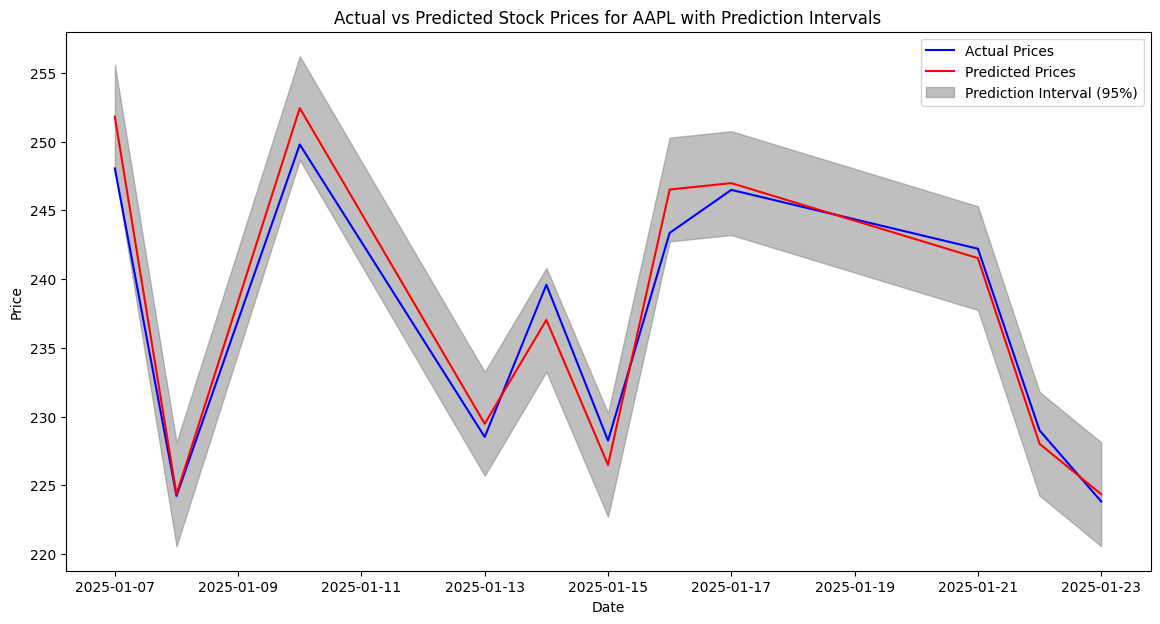

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
The predicted closing price for the next trading day for AAPL is: 226.09


In [106]:
# Function to calculate prediction intervals
def calculate_prediction_intervals(model, X_test, y_test, alpha=0.05):
    # Make predictions
    y_pred = model.predict(X_test).flatten()

    # Calculate residuals
    residuals = y_test - y_pred

    # Estimate the standard deviation of the residuals
    std_dev = np.std(residuals)

    # Calculate the z-score for the desired confidence level
    z_score = 1.96  # For a 95% confidence interval

    # Calculate the margin of error
    margin_of_error = z_score * std_dev

    # Calculate lower and upper bounds of the prediction intervals
    lower_bound = y_pred - margin_of_error
    upper_bound = y_pred + margin_of_error

    return y_pred, lower_bound, upper_bound

def main():
    ticker = input("Enter the stock ticker (e.g., AAPL): ")

    data = fetch_stock_data(ticker)

    # Filter to keep only the last 100 trading days
    data = data.tail(90)  # Use tail to get the last 100 days

    data = calculate_features(data)
    data, features = preprocess_data(data)

    # Prepare data for LSTM
    window_size = 10  # You can change this value to experiment
    X, y, feature_scaler, target_scaler = prepare_data(data, features, window_size)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = train_lstm_model(X_train, y_train, X_test, y_test)

    # Calculate prediction intervals
    y_pred, lower_bound, upper_bound = calculate_prediction_intervals(model, X_test, y_test)

    # Inverse transform the predictions and bounds
    y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    lower_bound = target_scaler.inverse_transform(lower_bound.reshape(-1, 1)).flatten()
    upper_bound = target_scaler.inverse_transform(upper_bound.reshape(-1, 1)).flatten()
    y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100  # Avoid division by zero

    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')

    # Plotting Actual vs Predicted with Prediction Intervals
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[-len(y_test):], y_test, label='Actual Prices', color='blue')
    plt.plot(data.index[-len(y_test):], y_pred, label='Predicted Prices', color='red')
    plt.fill_between(data.index[-len(y_test):], lower_bound, upper_bound, color='gray', alpha=0.5, label='Prediction Interval (95%)')
    plt.title(f'Actual vs Predicted Stock Prices for {ticker} with Prediction Intervals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Predict the next day's stock price
    predicted_price = predict_next_day(model, data, features, feature_scaler, target_scaler, window_size)
    print(f"The predicted closing price for the next trading day for {ticker} is: {predicted_price:.2f}")

if __name__ == "__main__":
    main()